In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/rooftop-segmentation-master"

/content/drive/MyDrive/rooftop-segmentation-master


In [3]:
%pip install keras

In [4]:
%pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,concatenate
# print(keras.__version__)
print(tensorflow.__version__)

2.15.0


In [5]:
!ls

model.py  __pycache__  README.md  rooftop-segmentation-roelof-kuipers.ipynb  test  train


Training images:  ['284.png', '303.png', '345.png', '301.png', '272.png', '320.png', '300.png', '287.png', '343.png', '314.png', '324.png', '270.png', '379.png', '241.png', '381.png', '308.png', '274.png', '328.png', '278.png', '317.png', '121.png', '417.png', '337.png', '315.png', '532.png']
Inspect 1 train image
Max value:  1.0
Image shape:  (256, 256, 4)


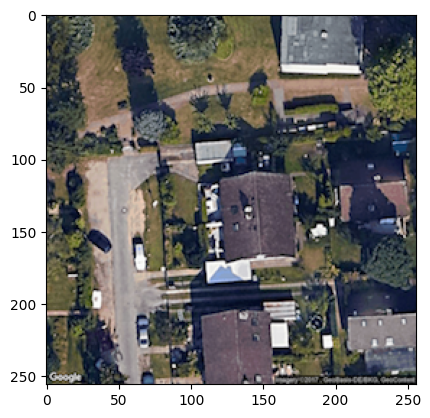

In [6]:
print('Training images: ', os.listdir("train/images"))
print('Inspect 1 train image')
img = plt.imread(os.path.join("train/images/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
imgplot = plt.imshow(img)

Inspect 1 train mask
Max value:  1.0
Image shape:  (256, 256)
Pixels in (256,256) img with value 1 : 9200
Pixels in (256,256) img with value 0 : 52917
Pixels in (256,256) img with value between 0 and 1 : 3419


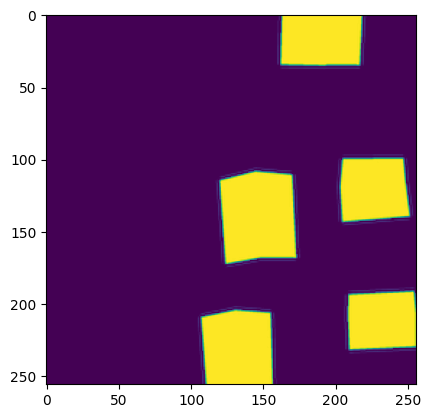

In [7]:
print('Inspect 1 train mask')
img = plt.imread(os.path.join("train/labels/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
print('Pixels in (256,256) img with value 1 :',np.sum(img==1.0))
print('Pixels in (256,256) img with value 0 :',np.sum(img==0.0))
print('Pixels in (256,256) img with value between 0 and 1 :',np.sum(img>0.0)-np.sum(img==1.0))
imgplot = plt.imshow(img)

Define the data generator

Define the types of augmentations

In [8]:
aug_dict = dict(rotation_range=0.2,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.05,
                horizontal_flip=True,
                fill_mode='nearest')

Define the data generators

In [9]:
image_datagen = ImageDataGenerator(**aug_dict)
mask_datagen = ImageDataGenerator(**aug_dict)

Define the right folders

In [10]:
batch_size=2
train_path='train'
image_folder='images'
mask_folder='labels'
image_color_mode='rgba'
mask_color_mode='grayscale'
target_size=(256,256)
seed=1

In [11]:
image_generator = image_datagen.flow_from_directory(
    train_path,
    classes = [image_folder],
    class_mode = None,
    color_mode = image_color_mode,
    target_size = target_size,
    batch_size = batch_size,
    seed = seed)
mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes = [mask_folder],
    class_mode = None,
    color_mode = mask_color_mode,
    target_size = target_size,
    batch_size = batch_size,
    seed = seed)
train_generator = zip(image_generator, mask_generator)

Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


In [12]:
def Generator(train_generator):
  for (img,mask) in train_generator:
      if(np.max(img) > 1):
        img = img / 255.
        mask = mask /255.
      mask[mask > 0.5] = 1
      mask[mask <= 0.5] = 0
      yield (img,mask)

myGene = Generator(train_generator)

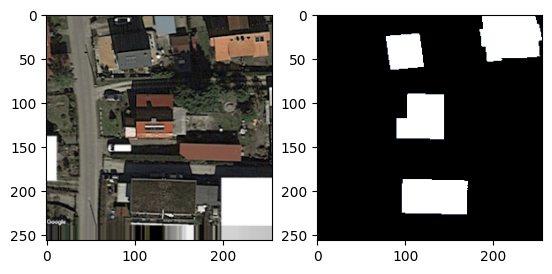

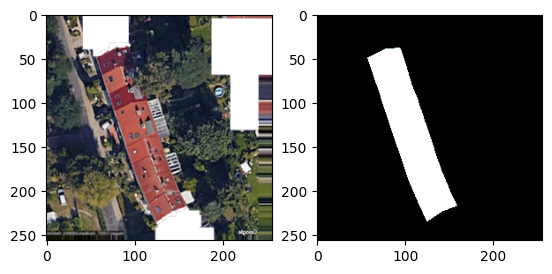

In [13]:
for b in range(1):
    example = next(myGene)
    for i in range(batch_size):
      img=example[0][i]
      mask=example[1][i]
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img.squeeze(), cmap=plt.get_cmap('bone'))
      ax[1].imshow(mask.squeeze(), cmap=plt.get_cmap('bone'))
      fig.show()

In [14]:
mask=example[1][0]
print('Verify only 1 and 0 in mask:\n')
print('pix in mask with value 1 :',np.sum(mask==1.0))
print('pix in mask with value 0 :',np.sum(mask==0.0))
print('pix in mask with value no 0 or 1 :',np.sum(mask>0.0)-np.sum(mask==1.0))

Verify only 1 and 0 in mask:

pix in mask with value 1 : 10003
pix in mask with value 0 : 55533
pix in mask with value no 0 or 1 : 0


 Augmentations of one mask

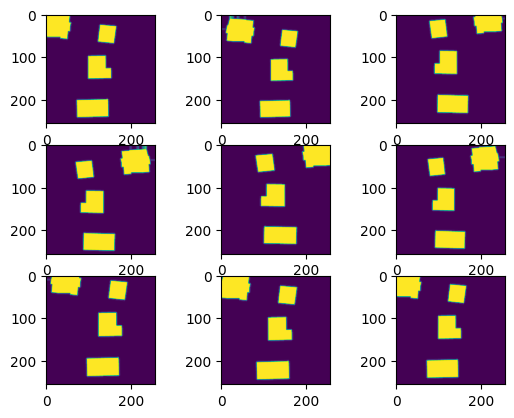

In [15]:
i=0
for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = mask_generator[0][0]
	plt.imshow(batch.squeeze())
plt.show()

Training Unet

In [16]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)
    return model

In [17]:
epochs=10
steps_per_epoch=300

model = unet(input_size = (256,256,4))
model.fit_generator(myGene,steps_per_epoch=steps_per_epoch,epochs=epochs)

<ipython-input-17-d9f32e975010>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(myGene,steps_per_epoch=steps_per_epoch,epochs=epochs)


Epoch 1/10
300/300 [==============================] - 104s 259ms/step - loss: 67.3420 - accuracy: 0.8559
Epoch 2/10
300/300 [==============================] - 53s 176ms/step - loss: 0.4086 - accuracy: 0.8561
Epoch 3/10
300/300 [==============================] - 52s 175ms/step - loss: 0.4226 - accuracy: 0.8555
Epoch 4/10
300/300 [==============================] - 52s 174ms/step - loss: 0.4082 - accuracy: 0.8569
Epoch 5/10
300/300 [==============================] - 52s 175ms/step - loss: 0.4127 - accuracy: 0.8555
Epoch 6/10
300/300 [==============================] - 52s 175ms/step - loss: 0.4077 - accuracy: 0.8561
Epoch 7/10
300/300 [==============================] - 52s 174ms/step - loss: 0.4072 - accuracy: 0.8559
Epoch 8/10
300/300 [==============================] - 52s 174ms/step - loss: 0.4058 - accuracy: 0.8562
Epoch 9/10
300/300 [==============================] - 52s 174ms/step - loss: 0.4055 - accuracy: 0.8559
Epoch 10/10
300/300 [==============================] - 52s 173ms/step -

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_path='test'
image_folder='images'

test_generator = test_datagen.flow_from_directory(
        test_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = 1)

filenames = [x[-7:] for x in test_generator.filenames]
test_samples = len(filenames)

results = model.predict_generator(test_generator,steps = test_samples, verbose=1)

Found 5 images belonging to 1 classes.


<ipython-input-18-06865d18152d>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_generator,steps = test_samples, verbose=1)


5/5 [==============================] - 3s 721ms/step


In [19]:
def saveResult(save_path,results,filenames):
    for i,item in enumerate(results):
        img = item[:,:,0]
        img_name = filenames[i]
        io.imsave(os.path.join(save_path, img_name),img)

saveResult("test/labels/",(results*255).astype(np.uint8), filenames)

Test images:  ['553.png', '539.png', '535.png', '551.png', '537.png']
Test image


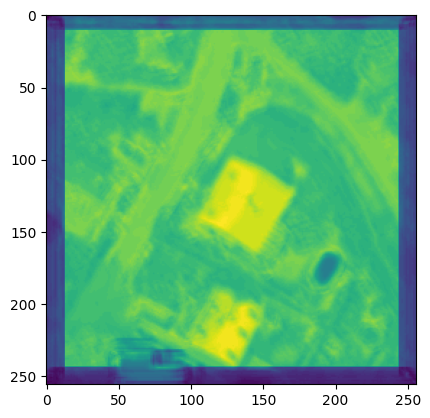

In [22]:
print('Test images: ', os.listdir("test/images"))
print('Test image')
img = plt.imread(os.path.join("test/images/535.png"))
img1 = plt.imread(os.path.join("test/labels/535.png"))
imgplot = plt.imshow(img)
imgplot = plt.imshow(img1)